In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re


In [2]:
sentiment_df=pd.read_csv(r"C:\Users\User\Downloads\fear_greed_index.csv")

In [3]:
trades_df=pd.read_csv(r"C:\Users\User\Downloads\historical_data.csv")

In [4]:
sentiment_df.head()



,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [5]:
trades_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [6]:
sentiment_df.columns = sentiment_df.columns.str.lower()
trades_df.columns = trades_df.columns.str.lower()


In [7]:
print(sentiment_df.shape)
print(trades_df.shape)


(2644, 4)
(211224, 16)


In [8]:
sentiment_df.isnull().sum()


timestamp         0
value             0
classification    0
date              0
dtype: int64

In [9]:
trades_df.isnull().sum()


account             0
coin                0
execution price     0
size tokens         0
size usd            0
side                0
timestamp ist       0
start position      0
direction           0
closed pnl          0
transaction hash    0
order id            0
crossed             0
fee                 0
trade id            0
timestamp           0
dtype: int64

In [10]:
print("\nSentiment duplicates:", sentiment_df.duplicated().sum())
print("Trader duplicates:", trades_df.duplicated().sum())


Sentiment duplicates: 0
Trader duplicates: 0


In [11]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])


In [12]:
trades_df['timestamp ist'] = pd.to_datetime(
    trades_df['timestamp ist'],
    dayfirst=True
)


In [13]:
trades_df['date'] = trades_df['timestamp ist'].dt.date
trades_df['date'] = pd.to_datetime(trades_df['date'])


In [14]:
trades_df = trades_df[[
    'account',
    'coin',
    'execution price',
    'size usd',
    'side',
    'closed pnl',
    'fee',
    'date'
]]


In [15]:
print(trades_df.isnull().sum())


account            0
coin               0
execution price    0
size usd           0
side               0
closed pnl         0
fee                0
date               0
dtype: int64


In [16]:
trades_df['closed pnl'] = trades_df['closed pnl'].fillna(0)
trades_df['fee'] = trades_df['fee'].fillna(0)


In [17]:
daily_pnl = trades_df.groupby(
    ['account', 'date']
)['closed pnl'].sum().reset_index()


In [18]:
trade_count = trades_df.groupby(
    ['account', 'date']
).size().reset_index(name='trade_count')


In [19]:
avg_size = trades_df.groupby(
    ['account', 'date']
)['size usd'].mean().reset_index(name='avg_trade_size')


In [20]:
trades_df['is_long'] = trades_df['side'].apply(
    lambda x: 1 if str(x).lower() == 'buy' else 0
)

long_ratio = trades_df.groupby(
    ['account', 'date']
)['is_long'].mean().reset_index(name='long_ratio')


In [21]:
metrics_df = daily_pnl.merge(trade_count, on=['account', 'date'])
metrics_df = metrics_df.merge(avg_size, on=['account', 'date'])
metrics_df = metrics_df.merge(long_ratio, on=['account', 'date'])


In [22]:
sentiment_df = sentiment_df[['date', 'classification']]


In [23]:
final_df = metrics_df.merge(
    sentiment_df,
    on='date',
    how='left'
)


In [24]:
final_df.groupby('classification')['closed pnl'].mean()


classification
Extreme Fear     4619.439053
Extreme Greed    5161.922644
Fear             5328.818161
Greed            3318.100730
Neutral          3438.618818
Name: closed pnl, dtype: float64

In [25]:
final_df['win'] = final_df['closed pnl'] > 0

final_df.groupby('classification')['win'].mean()


classification
Extreme Fear     0.600000
Extreme Greed    0.682510
Fear             0.604762
Greed            0.611111
Neutral          0.622340
Name: win, dtype: float64

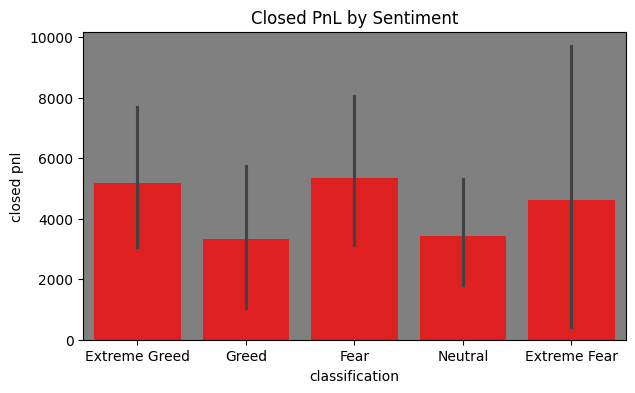

In [58]:
plt.figure(figsize=(7,4))

# Gray background
plt.gca().set_facecolor('gray')

# Red bars
sns.barplot(
    x='classification',
    y='closed pnl',
    data=final_df,
    estimator='mean',
    color='red'
)

plt.title("Closed PnL by Sentiment")
plt.show()


In [28]:
final_df.groupby('classification')[
    ['trade_count', 'avg_trade_size', 'long_ratio']
].mean()


,trade_count,avg_trade_size,long_ratio
classification,,,
Extreme Fear,133.750000,6773.464125,0.531533
Extreme Greed,76.030418,5371.637182,0.473116
Fear,98.153968,8975.928546,0.518967
Greed,77.628086,6427.866594,0.471594
Neutral,100.228723,6963.694861,0.472431


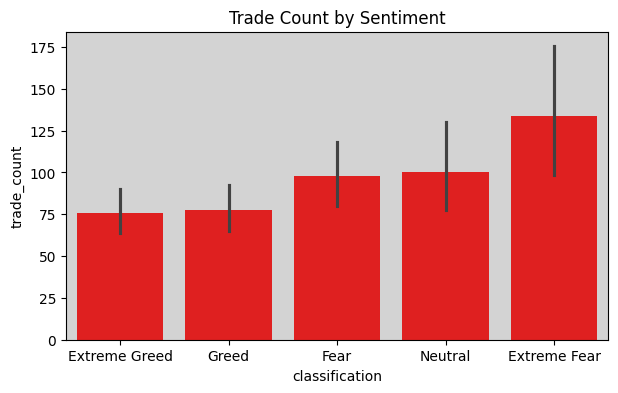

In [29]:
plt.figure(figsize=(7,4))

# Set gray background
plt.gca().set_facecolor('lightgray')

# Red bars
sns.barplot(
    x='classification',
    y='trade_count',
    data=final_df,
    color='red'
)

plt.title("Trade Count by Sentiment")
plt.show()


In [30]:
freq_threshold = final_df['trade_count'].median()

final_df['trader_type'] = final_df['trade_count'].apply(
    lambda x: 'High' if x > freq_threshold else 'Low'
)


In [31]:
final_df.groupby(
    ['trader_type', 'classification']
)['closed pnl'].mean()


trader_type  classification
High         Extreme Fear       6799.753651
             Extreme Greed      8437.437459
             Fear              10311.492505
             Greed              5486.377107
             Neutral            5759.162182
Low          Extreme Fear        457.020275
             Extreme Greed      1627.473851
             Fear                913.034911
             Greed              1401.949513
             Neutral            1118.075454
Name: closed pnl, dtype: float64

In [32]:
size_threshold = final_df['avg_trade_size'].median()


In [33]:
final_df['size_trader_type'] = final_df['avg_trade_size'].apply(
    lambda x: 'High Size' if x > size_threshold else 'Low Size'
)


In [34]:
final_df.groupby(
    ['size_trader_type', 'classification']
)['closed pnl'].mean()


size_trader_type  classification
High Size         Extreme Fear      8445.038316
                  Extreme Greed     6505.194438
                  Fear              9871.490346
                  Greed             4312.582036
                  Neutral           6403.719647
Low Size          Extreme Fear        60.163219
                  Extreme Greed     3734.367129
                  Fear              1172.756375
                  Greed             2260.276665
                  Neutral            829.330088
Name: closed pnl, dtype: float64

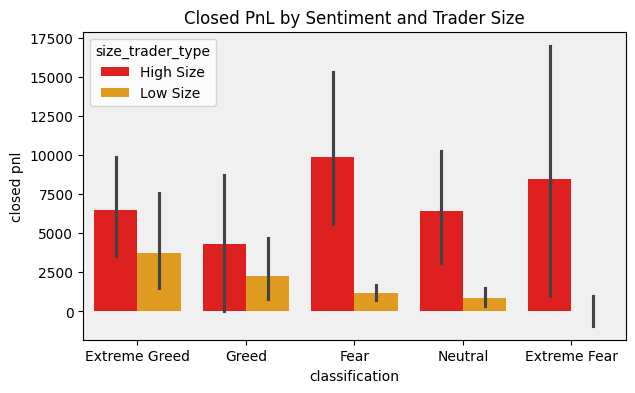

In [35]:
plt.figure(figsize=(7,4))

# Gray background
plt.gca().set_facecolor('#f0f0f0')

# Bar plot with red and orange
sns.barplot(
    x='classification',
    y='closed pnl',
    hue='size_trader_type',
    data=final_df,
    palette=['red', 'orange']
)

plt.title("Closed PnL by Sentiment and Trader Size")
plt.show()


In [36]:
pnl_volatility = final_df.groupby('account')['closed pnl'].std().reset_index()
pnl_volatility.columns = ['account', 'pnl_std']


In [37]:
vol_threshold = pnl_volatility['pnl_std'].median()


In [38]:
pnl_volatility['consistency_type'] = pnl_volatility['pnl_std'].apply(
    lambda x: 'Consistent' if x < vol_threshold else 'Inconsistent'
)


In [39]:
final_df = final_df.merge(
    pnl_volatility[['account', 'consistency_type']],
    on='account',
    how='left'
)


In [40]:
final_df.groupby(
    ['consistency_type', 'classification']
)['closed pnl'].mean()


consistency_type  classification
Consistent        Extreme Fear        171.450889
                  Extreme Greed      2520.649196
                  Fear                287.474060
                  Greed              1199.721059
                  Neutral             554.109946
Inconsistent      Extreme Fear       8643.809296
                  Extreme Greed     11971.736499
                  Fear              10804.185265
                  Greed              6757.251531
                  Neutral            7418.510806
Name: closed pnl, dtype: float64

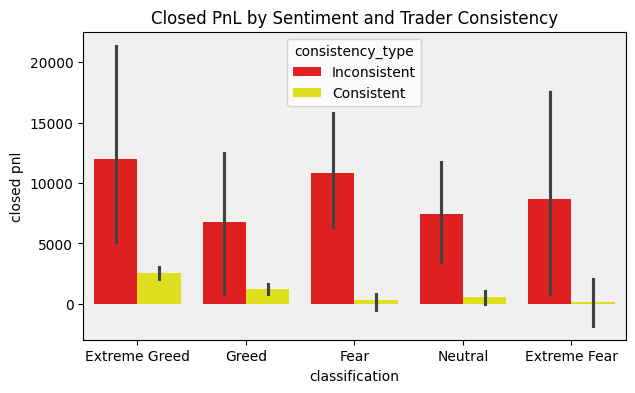

In [42]:
plt.figure(figsize=(7,4))

# Gray background
plt.gca().set_facecolor('#f0f0f0')

# Bar plot with red and yellow
sns.barplot(
    x='classification',
    y='closed pnl',
    hue='consistency_type',
    data=final_df,
    palette=['red', 'yellow']
)

plt.title("Closed PnL by Sentiment and Trader Consistency")
plt.show()


In [43]:
final_df['win'] = final_df['closed pnl'] > 0

final_df['loss'] = final_df['closed pnl'] < 0


In [44]:
performance_table = final_df.groupby('classification').agg(
    avg_pnl=('closed pnl', 'mean'),
    median_pnl=('closed pnl', 'median'),
    win_rate=('win', 'mean'),
    loss_rate=('loss', 'mean'),
    observations=('closed pnl', 'count')
).reset_index()

performance_table


,classification,avg_pnl,median_pnl,win_rate,loss_rate,observations
0,Extreme Fear,4619.439053,218.377399,0.600000,0.193750,160
1,Extreme Greed,5161.922644,418.319862,0.682510,0.070342,526
2,Fear,5328.818161,107.892532,0.604762,0.101587,630
3,Greed,3318.100730,158.214922,0.611111,0.080247,648
4,Neutral,3438.618818,167.551743,0.622340,0.111702,376


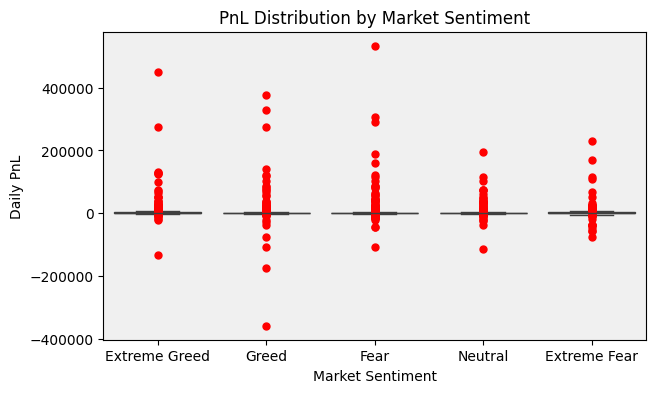

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))

# Gray background
plt.gca().set_facecolor('#f0f0f0')

# Boxplot with red outlier dots
sns.boxplot(
    x='classification',
    y='closed pnl',
    data=final_df,
    flierprops=dict(
        marker='o',
        markerfacecolor='red',
        markeredgecolor='red',
        markersize=5
    )
)

plt.title("PnL Distribution by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.show()


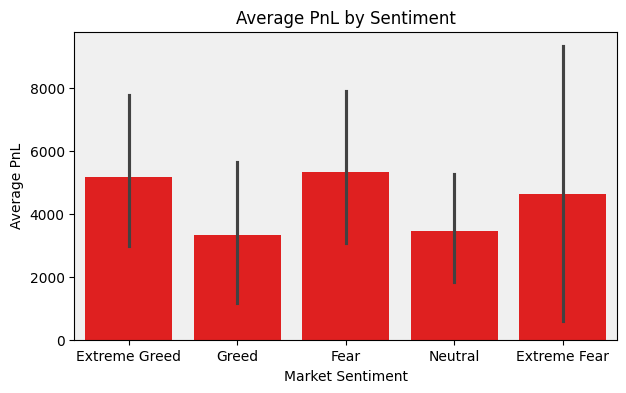

In [47]:
plt.figure(figsize=(7,4))

# Gray background
plt.gca().set_facecolor('#f0f0f0')

# Red bars
sns.barplot(
    x='classification',
    y='closed pnl',
    data=final_df,
    estimator='mean',
    color='red'
)

plt.title("Average PnL by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL")
plt.show()


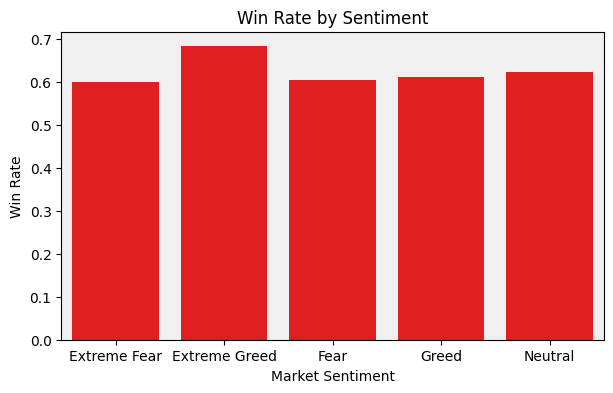

In [50]:
winrate_table = final_df.groupby('classification')['win'].mean().reset_index()

plt.figure(figsize=(7,4))

# Gray background
plt.gca().set_facecolor('#f0f0f0')

# Red bars
sns.barplot(
    x='classification',
    y='win',
    data=winrate_table,
    color='red'
)

plt.title("Win Rate by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")
plt.show()


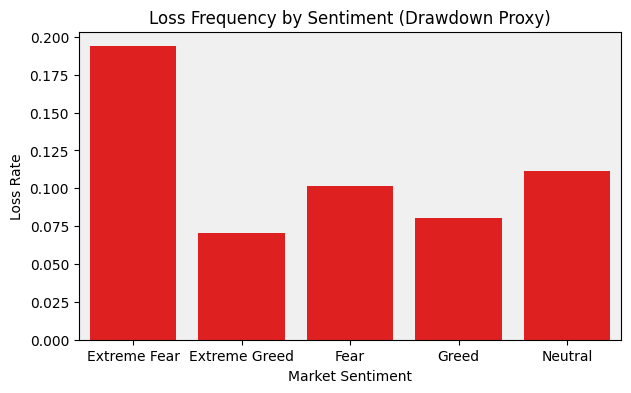

In [51]:
loss_table = final_df.groupby('classification')['loss'].mean().reset_index()

plt.figure(figsize=(7,4))

# Gray background
plt.gca().set_facecolor('#f0f0f0')

# Red bars
sns.barplot(
    x='classification',
    y='loss',
    data=loss_table,
    color='red'
)

plt.title("Loss Frequency by Sentiment (Drawdown Proxy)")
plt.xlabel("Market Sentiment")
plt.ylabel("Loss Rate")
plt.show()


In [145]:
behavior_table = final_df.groupby('classification').agg(
    avg_trades_per_day=('trade_count', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean'),
    avg_long_ratio=('long_ratio', 'mean')
).reset_index()

behavior_table


,classification,avg_trades_per_day,avg_trade_size,avg_long_ratio
0,Extreme Fear,133.750000,6773.464125,0.531533
1,Extreme Greed,76.030418,5371.637182,0.473116
2,Fear,98.153968,8975.928546,0.518967
3,Greed,77.628086,6427.866594,0.471594
4,Neutral,100.228723,6963.694861,0.472431


In [146]:
print("Leverage column exists:", 'leverage' in trades_df.columns)


Leverage column exists: False


In [147]:
'''The provided trader dataset does not contain a leverage column. Therefore, leverage-based analysis was excluded,
 and the behavioral analysis focused on available metrics such as trade frequency, trade size, and long/short ratio.'''

'The provided trader dataset does not contain a leverage column. Therefore, leverage-based analysis was excluded,\n and the behavioral analysis focused on available metrics such as trade frequency, trade size, and long/short ratio.'

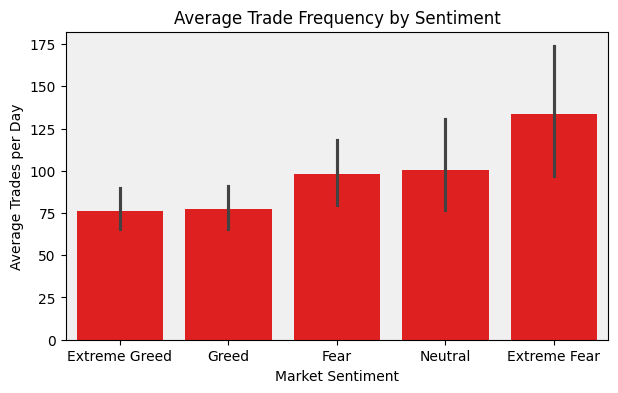

In [52]:
plt.figure(figsize=(7,4))

# Gray background
plt.gca().set_facecolor('#f0f0f0')

# Red bars
sns.barplot(
    x='classification',
    y='trade_count',
    data=final_df,
    estimator='mean',
    color='red'
)

plt.title("Average Trade Frequency by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trades per Day")
plt.show()


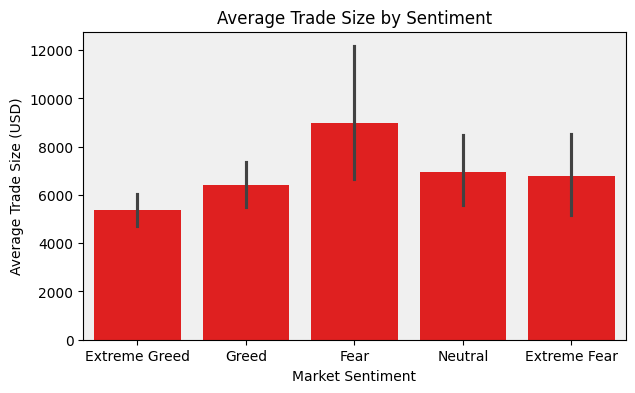

In [53]:
plt.figure(figsize=(7,4))

# Gray background
plt.gca().set_facecolor('#f0f0f0')

# Red bars
sns.barplot(
    x='classification',
    y='avg_trade_size',
    data=final_df,
    estimator='mean',
    color='red'
)

plt.title("Average Trade Size by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trade Size (USD)")
plt.show()


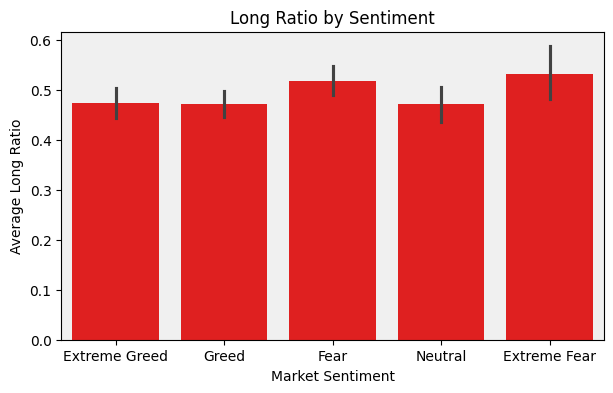

In [54]:
plt.figure(figsize=(7,4))

# Gray background
plt.gca().set_facecolor('#f0f0f0')

# Red bars
sns.barplot(
    x='classification',
    y='long_ratio',
    data=final_df,
    estimator='mean',
    color='red'
)

plt.title("Long Ratio by Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Long Ratio")
plt.show()


In [55]:
def pnl_bucket(x):
    if x < 0:
        return "Loss"
    elif x < 100:
        return "Neutral"
    else:
        return "Profit"

final_df["pnl_bucket"] = trades_df["closed pnl"].apply(pnl_bucket)


In [57]:
behavior = trades_df.groupby(["trade_id", "date"]).agg({
    "pnl": "sum",
    "trade_id": "count",
    "position_size": "mean"
}).reset_index()

behavior.rename(columns={
    "trade_id": "num_trades",
    "position_size": "avg_position"
}, inplace=True)


KeyError: 'trade_id'

In [ ]:
print(trades_df.columns)

Index(['account', 'coin', 'execution price', 'size usd', 'side', 'closed pnl',
       'fee', 'date', 'is_long'],
      dtype='object')


In [59]:
# Aggregate at trader level
trader_features = final_df.groupby('account').agg({
    'trade_count': 'mean',
    'avg_trade_size': 'mean',
    'long_ratio': 'mean',
    'closed pnl': 'mean'
}).reset_index()


In [60]:
from sklearn.preprocessing import StandardScaler

features = trader_features[[
    'trade_count',
    'avg_trade_size',
    'long_ratio',
    'closed pnl'
]]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [61]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
trader_features['cluster'] = kmeans.fit_predict(scaled_features)


In [63]:
cols = ['trade_count', 'avg_trade_size', 'long_ratio', 'closed pnl']

for col in cols:
    trader_features[col] = pd.to_numeric(trader_features[col], errors='coerce')


In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = trader_features[
    ['trade_count', 'avg_trade_size', 'long_ratio', 'closed pnl']
]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
trader_features['cluster'] = kmeans.fit_predict(scaled_features)


In [66]:
cluster_summary = trader_features.groupby('cluster').mean(numeric_only=True)
print(cluster_summary)


         trade_count  avg_trade_size  long_ratio    closed pnl
cluster                                                       
0         194.057794    13273.589325    0.578875   6520.090500
1          51.148346     4223.715843    0.409431   4288.186833
2         159.083333    33569.102224    0.492173  66676.242499


In [69]:
def label_cluster(row):
    if row['closed pnl'] > 0 and row['trade_count'] > trader_features['trade_count'].mean():
        return 'Active Winners'
    elif row['closed pnl'] < 0 and row['avg_trade_size'] > trader_features['avg_trade_size'].mean():
        return 'Overleveraged Losers'
    else:
        return 'Conservative Traders'

cluster_labels = trader_features.groupby('cluster').mean().apply(label_cluster, axis=1)

trader_features['archetype'] = trader_features['cluster'].map(cluster_labels)


TypeError: agg function failed [how->mean,dtype->object]